In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [405]:
data=pd.read_csv("~/Desktop/combinedf.csv",parse_dates=['Date'])
data=data[['Date','Sales','Year','Month','Day','Hour']]
#data=data[data['Sales']!=0]

In [406]:
data.head()

,Date,Sales,Year,Month,Day,Hour
0,2015-01-01 10:15:00,662,2015,1,1,10
1,2015-01-01 10:30:00,740,2015,1,1,10
2,2015-01-01 10:45:00,655,2015,1,1,10
3,2015-01-01 11:00:00,751,2015,1,1,11
4,2015-01-01 11:15:00,730,2015,1,1,11


In [407]:
time_stamp=[]
from datetime import datetime
for year,month,day,hour in zip(data['Year'],data['Month'],data['Day'],data['Hour']):
    concat_date=datetime(year,month,day,hour)
    time_stamp.append(concat_date)

In [408]:
data['time_stamp']=pd.DataFrame(time_stamp)


In [409]:
data_hour=(data.groupby(data['time_stamp']).sum()).reset_index()
data_hour.head()

,time_stamp,Sales,Year,Month,Day,Hour
0,2015-01-01 10:00:00,2057,6045,3,3,30
1,2015-01-01 11:00:00,3071,8060,4,4,44
2,2015-01-01 12:00:00,3054,8060,4,4,48
3,2015-01-01 13:00:00,3403,8060,4,4,52
4,2015-01-01 14:00:00,3453,8060,4,4,56


In [410]:
data_hour=data_hour.drop(['Year','Month','Day','Hour'],axis=1)

In [411]:
data_hour.head()

,time_stamp,Sales
0,2015-01-01 10:00:00,2057
1,2015-01-01 11:00:00,3071
2,2015-01-01 12:00:00,3054
3,2015-01-01 13:00:00,3403
4,2015-01-01 14:00:00,3453


In [412]:
data_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13957 entries, 0 to 13956
Data columns (total 2 columns):
time_stamp    13957 non-null datetime64[ns]
Sales         13957 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 218.2 KB


In [413]:
data_hour['date']=data_hour['time_stamp'].dt.date

In [414]:
hour=pd.DataFrame(data_hour['date'].value_counts())
hour.shape

(1221, 1)

Text(0.5, 1.0, 'Hours of Sale by Month')

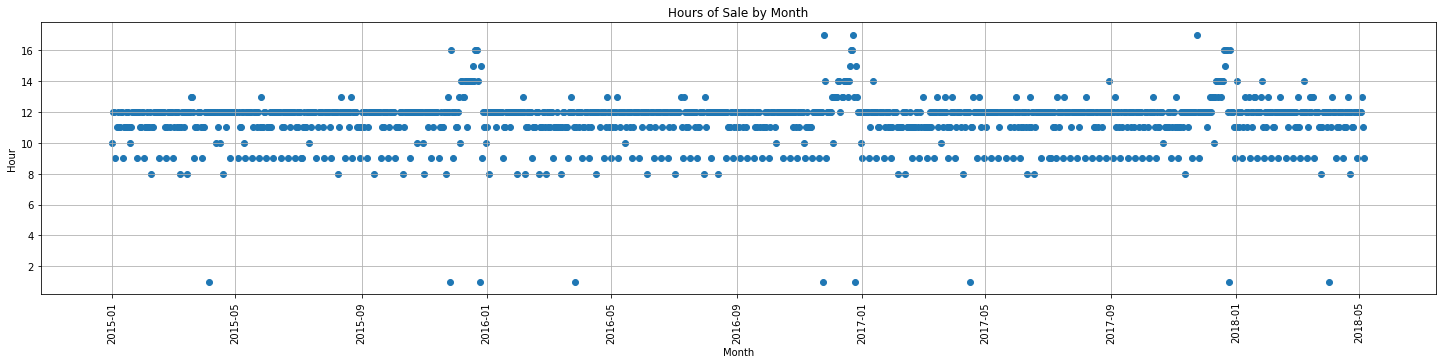

In [415]:
fig= plt.figure(figsize=(25,5))
plt.scatter(pd.DatetimeIndex(hour.index),hour.date)
plt.xticks(rotation='vertical')
plt.grid()
plt.xlabel("Month")
plt.ylabel("Hour")
plt.title("Hours of Sale by Month")

#Inference: By avergae we can see most of the days the shop has sale for at least 12 hours. 
#In some cases sale occured for more than 12 hours. Maximum is 17 hours and 0 onl days of holiday.

In [416]:
data_hour.set_index(['time_stamp'],inplace=True)

In [417]:
data_hour=data_hour.drop(['date'],axis=1)
data_hour.head()

,Sales
time_stamp,
2015-01-01 10:00:00,2057
2015-01-01 11:00:00,3071
2015-01-01 12:00:00,3054
2015-01-01 13:00:00,3403
2015-01-01 14:00:00,3453


In [418]:
def rolling_mean_std(data,windowsize):
    """
        data - sales data
        windowsize - rolling window size by hours
        
    """
    rolling_mean = data.rolling(window=windowsize).mean()
    rolling_std = data.rolling(window=windowsize).std()

    plt.figure(figsize=(15,5))
    plt.title("{} - Rolling Mean and Std for {} hours window".format(data.name,windowsize),fontsize=16)
    
    plt.plot(rolling_mean, color='red')
    #plt.plot(rolling_std,color='green')
    plt.plot(data,color='blue')
    
   
    plt.grid(True)
    plt.legend(('Roliing Mean','Rolling Std','Actual Data'),fontsize=12,loc="upper left")
    plt.xticks(rotation='vertical',fontsize=12)


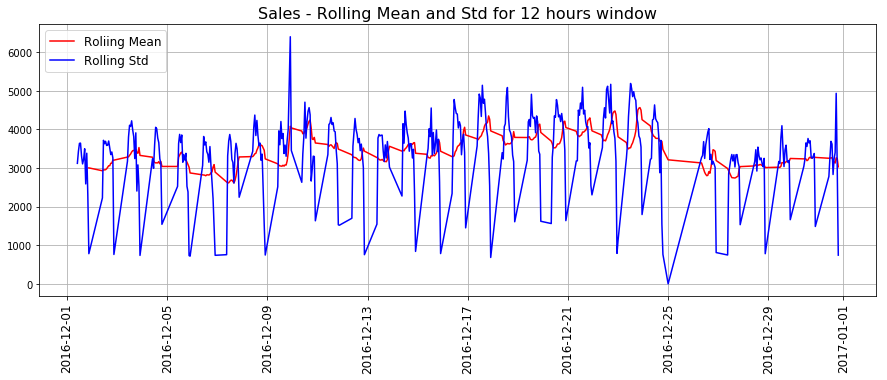

In [419]:
rolling_mean_std(data_hour['Sales'][(pd.DatetimeIndex(data_hour.index).year==2016)&(pd.DatetimeIndex(data_hour.index).month==12)], 12) 

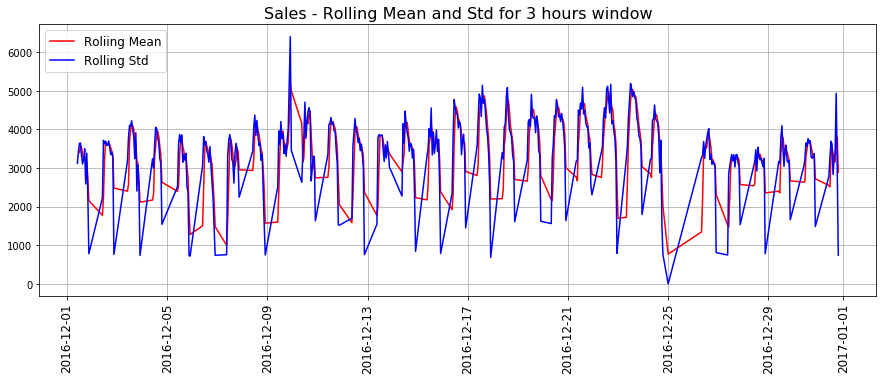

In [420]:
rolling_mean_std(data_hour['Sales'][(pd.DatetimeIndex(data_hour.index).year==2016)&(pd.DatetimeIndex(data_hour.index).month==12)],3) 

In [421]:
from sklearn.metrics import mean_absolute_error
def detect_peaks(data,windowsize):
    scale=1.5
    rolling_mean = data.rolling(window=windowsize).mean()
    rolling_std = data.rolling(window=windowsize).std()
    mae = mean_absolute_error(data[windowsize:], rolling_mean[windowsize:])
    deviation = np.std(data[windowsize:] - rolling_mean[windowsize:])
    lower_bound = rolling_mean - (mae + scale * deviation)
    upper_bound = rolling_mean + (mae + scale * deviation)
    
    peaks=pd.DataFrame(index=data.index,columns=data.columns)
    peaks[data<lower_bound]=data[data<lower_bound]
    peaks[data>upper_bound]=data[data>upper_bound]
    plt.plot(upper_bound, "g--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bound, "g--")
    plt.plot(peaks, "ro", markersize=5)

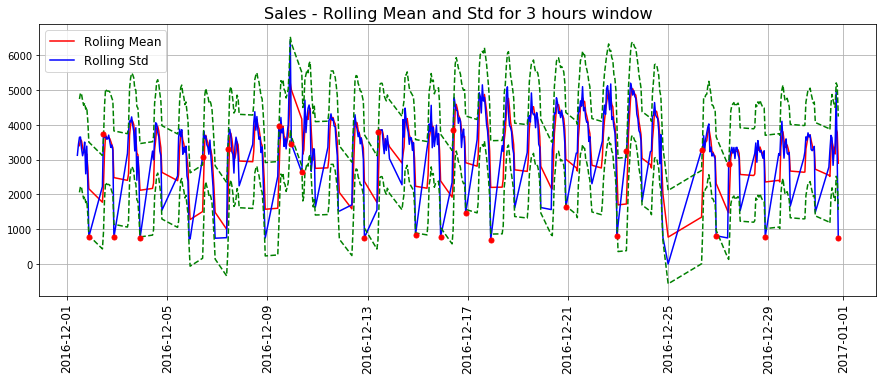

In [422]:
rolling_mean_std(data_hour['Sales'][(pd.DatetimeIndex(data_hour.index).year==2016)&(pd.DatetimeIndex(data_hour.index).month==12)],3) 
detect_peaks(data_hour[(pd.DatetimeIndex(data_hour.index).year==2016)&(pd.DatetimeIndex(data_hour.index).month==12)],3)

# Is the data Stationary?

In [399]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
adftest = adfuller(data_hour['Sales'], autolag='AIC')
adfoutput = pd.Series(adftest[0:4], index=['ADF Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
print (adfoutput)

#inference: P-valus is very much lower 0.05 indicating the it is highly significant. we can reject null hypothesis that the data has a unit root.
# data is stationary.

Results of Dickey-Fuller Test:
ADF Statistic                 -1.253226e+01
p-value                        2.414093e-23
#Lags Used                     4.200000e+01
Number of Observations Used    1.391400e+04
Critical Value (1%)           -3.430820e+00
Critical Value (5%)           -2.861748e+00
Critical Value (10%)          -2.566881e+00
dtype: float64


In [201]:
#to confirm no differencing is required ndiffs() can be used
from pmdarima.arima.utils import ndiffs
print("ADF Test: ",ndiffs(data_hour['Sales'], test='adf'))  # 2


ADF Test:  0


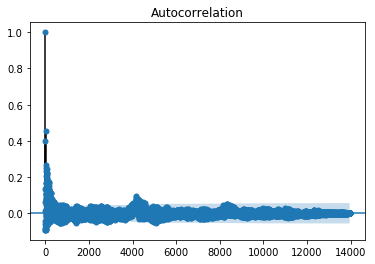

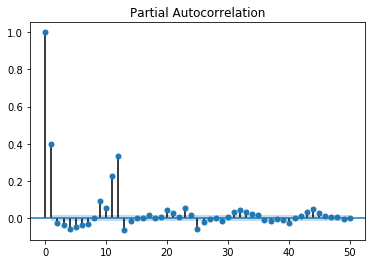

In [428]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(data_hour['Sales'])
plt.show()
plot_pacf(data_hour['Sales'], lags=50)
plt.show()

In [ ]:
#Inference:ACF and PACF plot die immediately 

# ARIMA model

In [202]:
from statsmodels.tsa.stattools import acf

train = data_hour['Sales'][np.logical_not((pd.DatetimeIndex(data_hour.index).year==2017)&(pd.DatetimeIndex(data_hour.index).month==12))]
test = data_hour['Sales'][(pd.DatetimeIndex(data_hour.index).year==2017)&(pd.DatetimeIndex(data_hour.index).month==12)]

In [203]:
train.shape

(13566,)

Fit ARIMA: order=(0, 0, 0); AIC=218608.479, BIC=218623.510, Fit time=0.013 seconds
Fit ARIMA: order=(1, 0, 0); AIC=216534.845, BIC=216557.391, Fit time=0.047 seconds
Fit ARIMA: order=(0, 0, 1); AIC=216702.406, BIC=216724.952, Fit time=0.039 seconds
Fit ARIMA: order=(2, 0, 0); AIC=216516.539, BIC=216546.600, Fit time=0.078 seconds
Fit ARIMA: order=(2, 0, 1); AIC=216433.424, BIC=216471.000, Fit time=1.975 seconds
Fit ARIMA: order=(3, 0, 2); AIC=215423.069, BIC=215475.676, Fit time=4.736 seconds
Fit ARIMA: order=(2, 0, 2); AIC=216381.733, BIC=216426.825, Fit time=2.608 seconds
Fit ARIMA: order=(4, 0, 2); AIC=215368.495, BIC=215428.618, Fit time=5.592 seconds
Fit ARIMA: order=(4, 0, 1); AIC=216366.932, BIC=216419.539, Fit time=2.183 seconds
Fit ARIMA: order=(4, 0, 3); AIC=215425.347, BIC=215492.985, Fit time=9.053 seconds
Fit ARIMA: order=(3, 0, 1); AIC=216404.856, BIC=216449.948, Fit time=2.437 seconds
Fit ARIMA: order=(5, 0, 3); AIC=215360.785, BIC=215435.938, Fit time=11.793 seconds
Fit

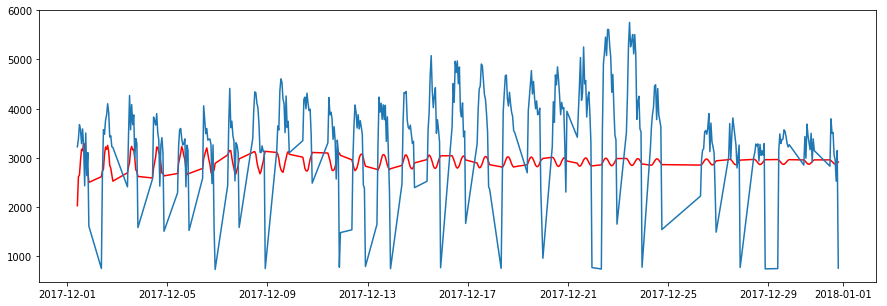

In [204]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       
                      max_p=8, max_q=8, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# Forecast
n_periods = 390
plt.figure(figsize=(15,5))
pred = model.predict(n_periods=n_periods)

plt.plot(test[test>0].index,pred,color='red')
plt.plot(test[test>0].index,test[test>0])
print(model.summary())

In [206]:
from math import sqrt
sqrt(mean_absolute_error(fc,test[test>0]))

30.325739635691537

# Window Slicing Method

In [264]:
data=data.iloc[:,1:2].values

In [265]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(data)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [285]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(61, 13558):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [286]:
X_train.shape

(13497, 60)

In [287]:
y_train.shape

(13497,)

In [288]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(13497, 60, 1)

In [289]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [290]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [291]:
regressor.add(Dense(units = 1))

In [292]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [293]:
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
13497/13497 [==============================] - 81s 6ms/step - loss: 0.0019
Epoch 2/10
13497/13497 [==============================] - 82s 6ms/step - loss: 0.0010
Epoch 3/10
13497/13497 [==============================] - 77s 6ms/step - loss: 9.1079e-04
Epoch 4/10
13497/13497 [==============================] - 71s 5ms/step - loss: 8.3589e-04
Epoch 5/10
13497/13497 [==============================] - 70s 5ms/step - loss: 7.8572e-04
Epoch 6/10
13497/13497 [==============================] - 70s 5ms/step - loss: 7.4552e-04
Epoch 7/10
13497/13497 [==============================] - 71s 5ms/step - loss: 7.1612e-04
Epoch 8/10
13497/13497 [==============================] - 70s 5ms/step - loss: 6.8498e-04
Epoch 9/10
13497/13497 [==============================] - 70s 5ms/step - loss: 6.8398e-04
Epoch 10/10
13497/13497 [==============================] - 70s 5ms/step - loss: 6.7414e-04


In [380]:
data=pd.read_csv("~/Desktop/combinedf.csv",parse_dates=['Date'])
data=data.iloc[:,1:2].values
inputs = data.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(13559, 13948):
    
    X_test.append(inputs[i-60:i, 0])
    
X_test = np.array(X_test)
actual=X_test
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_sales = regressor.predict(X_test)
predicted_sales = sc.inverse_transform(predicted_sales)

In [395]:
data=pd.read_csv("~/Desktop/combinedf.csv",parse_dates=['Date'])
actual=data.iloc[13559:13948,1:2]

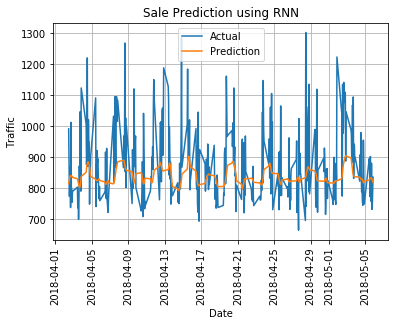

In [398]:
plt.plot(data_hour[13559:13948].index,actual)
plt.plot(data_hour[13559:13948].index,predicted_sales)
plt.xticks(rotation='vertical')
plt.title("Sale Prediction using RNN")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Traffic")
plt.legend(("Actual","Prediction"))

In [396]:
sqrt(mean_absolute_error(actual,predicted_sales))

9.333919498801349

In [ ]:
#RNN has captured the variations only to a certain extent. RMSE is quite high.